In [1]:
import pandas as pd
import numpy as np
import os
import math
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torch.nn.parameter import Parameter
from torch.autograd import Variable
from sklearn import metrics
from sklearn.model_selection import KFold, train_test_split
from scipy.stats import pearsonr
import torch.nn as nn
import torch.nn.functional as F

In [2]:
# Seed
SEED = 2333
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.set_device(1)
    torch.cuda.manual_seed(SEED)

In [3]:
# Model parameters
NUMBER_EPOCHS = 10
LEARNING_RATE = 1E-4
WEIGHT_DECAY = 1E-4
BATCH_SIZE = 1
NUM_CLASSES = 1

# GCN parameters
GCN_FEATURE_DIM = 30
GCN_HIDDEN_DIM = 256
GCN_OUTPUT_DIM = 64   #이거 8이나 4로 바꿔보자

# Attention parameters
DENSE_DIM = 16
ATTENTION_HEADS = 4

In [4]:
def normalize(mx):
    rowsum = np.array(mx.sum(1))
    r_inv = (rowsum ** -0.5).flatten()
    r_inv[np.isinf(r_inv)] = 0
    r_mat_inv = np.diag(r_inv)
    result = r_mat_inv @ mx @ r_mat_inv
    return result

In [48]:

def load_features(label_number, mean, std):

    # len(sequence) * 23
    blosum_matrix = np.load('C:\\Users\\johnkwon\\Desktop\\[Ultima]_Solubility\\Data\\Ecoli_data\\Testing\\GCN\\Blosum features\\' + str(label_number) + '.npy')
    
    # len(sequence) * 30
    a7_matrix = np.load('C:\\Users\\johnkwon\\Desktop\\[Ultima]_Solubility\\Data\\Ecoli_data\\Testing\\GCN\\7A features\\' + str(label_number) + '.npy')
       
    # len(sequence) * 33
    coord_matrix = np.load('C:\\Users\\johnkwon\\Desktop\\[Ultima]_Solubility\\Data\\Ecoli_data\\Testing\\GCN\\Acarbon_coordinates_centered\\' + str(label_number) + '.npy')
 

    #print(label_number)
    feature_matrix = np.concatenate([blosum_matrix,a7_matrix,coord_matrix], axis=1)
    feature_matrix = (feature_matrix - mean) / std
    part1 = feature_matrix[:,0:20]
    part2 = feature_matrix[:,23:]
    # len(sequence) * 30
    feature_matrix = np.concatenate([part1,part2],axis=1)
    return feature_matrix

In [6]:
def load_values():
    mean = np.load("C:\\Users\\johnkwon\\Desktop\\[Ultima]_Solubility\\Data\\Ecoli_data\\Scaling\\GCN\\mean_matrix.npy")
    std = np.load("C:\\Users\\johnkwon\\Desktop\\[Ultima]_Solubility\\Data\\Ecoli_data\\Scaling\\GCN\\std_matrix.npy")
    return mean, std

In [46]:
def load_graph(label_number): ###################################################################################1
    matrix = np.load("C:\\Users\\johnkwon\\Desktop\\[Ultima]_Solubility\\Data\\Ecoli_data\\Testing\\GCN\\Contact_maps_12A\\" + str(label_number) + '.npy').astype(np.float32)
    edge_matrix = normalize(matrix)
    return edge_matrix

In [8]:
class ProDataset(Dataset):

    def __init__(self, dataframe):
        self.label = dataframe['Number'].values
        self.solubility = dataframe['solubility'].values
        self.mean, self.std = load_values()

    def __getitem__(self, index):
        sequence_label = self.label[index]
        solubility = self.solubility[index]
        # L * 30
        sequence_feature = load_features(sequence_label, self.mean, self.std)
        # L * L
        sequence_graph = load_graph(sequence_label)
        
        return sequence_label, solubility, sequence_feature, sequence_graph

    def __len__(self):
        return len(self.solubility)

In [9]:
class GraphConvolution(nn.Module):

    def __init__(self, in_features, out_features, bias=True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        support = input @ self.weight    # X * W
        output = adj @ support           # A * X * W
        if self.bias is not None:        # A * X * W + b
            return output + self.bias
        else:
            return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' + str(self.in_features) + ' -> ' + str(self.out_features) + ')'


In [10]:
class GCN(nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.gc1 = GraphConvolution(GCN_FEATURE_DIM, GCN_HIDDEN_DIM)
        self.ln1 = nn.LayerNorm(GCN_HIDDEN_DIM)
        self.gc2 = GraphConvolution(GCN_HIDDEN_DIM, GCN_OUTPUT_DIM)
        self.ln2 = nn.LayerNorm(GCN_OUTPUT_DIM)
        self.relu1 = nn.LeakyReLU(0.2,inplace=True)
        self.relu2 = nn.LeakyReLU(0.2,inplace=True)

    def forward(self, x, adj):  			# x.shape = (seq_len, GCN_FEATURE_DIM); adj.shape = (seq_len, seq_len)
        x = self.gc1(x, adj)  				# x.shape = (seq_len, GCN_HIDDEN_DIM)
        x = self.relu1(self.ln1(x))
        x = self.gc2(x, adj)
        output = self.relu2(self.ln2(x))	# output.shape = (seq_len, GCN_OUTPUT_DIM)
        return output

In [11]:
class Attention(nn.Module):
    def __init__(self, input_dim, dense_dim, n_heads):
        super(Attention, self).__init__()
        self.input_dim = input_dim
        self.dense_dim = dense_dim
        self.n_heads = n_heads
        self.fc1 = nn.Linear(self.input_dim, self.dense_dim)
        self.fc2 = nn.Linear(self.dense_dim, self.n_heads)

    def softmax(self, input, axis=1):
        input_size = input.size()
        trans_input = input.transpose(axis, len(input_size) - 1)
        trans_size = trans_input.size()
        input_2d = trans_input.contiguous().view(-1, trans_size[-1])
        soft_max_2d = torch.softmax(input_2d, dim=1)
        soft_max_nd = soft_max_2d.view(*trans_size)
        return soft_max_nd.transpose(axis, len(input_size) - 1)

    def forward(self, input):  				# input.shape = (1, seq_len, input_dim)
        x = torch.tanh(self.fc1(input))  	# x.shape = (1, seq_len, dense_dim)
        x = self.fc2(x)  					# x.shape = (1, seq_len, attention_hops)
        x = self.softmax(x, 1)
        attention = x.transpose(1, 2)  		# attention.shape = (1, attention_hops, seq_len)
        return attention

In [12]:
class GCN_model(nn.Module):
    def __init__(self):
        super(GCN_model, self).__init__()

        self.gcn = GCN()
        self.attention = Attention(GCN_OUTPUT_DIM, DENSE_DIM, ATTENTION_HEADS)
        self.fc_final = nn.Linear(GCN_OUTPUT_DIM, NUM_CLASSES)

        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

    def forward(self, x, adj):  											# x.shape = (seq_len, FEATURE_DIM); adj.shape = (seq_len, seq_len)
        x = x.float()
        x = self.gcn(x, adj)  												# x.shape = (seq_len, GAT_OUTPUT_DIM)

        x = x.unsqueeze(0).float()  										# x.shape = (1, seq_len, GAT_OUTPUT_DIM)
        att = self.attention(x)  											# att.shape = (1, ATTENTION_HEADS, seq_len)
        node_feature_embedding = att @ x 									# output.shape = (1, ATTENTION_HEADS, GAT_OUTPUT_DIM)
        node_feature_embedding_avg = torch.sum(node_feature_embedding,
                                               1) / self.attention.n_heads  # node_feature_embedding_avg.shape = (1, GAT_OUTPUT_DIM)
        output = torch.sigmoid(self.fc_final(node_feature_embedding_avg))  	# output.shape = (1, NUM_CLASSES)
        output2 = self.fc_final(node_feature_embedding_avg)


        return output.squeeze(0)

In [13]:
GCN_model = GCN_model()

In [32]:


GCN_model_directory="C:\\Users\\johnkwon\\Desktop\\[Ultima]_Solubility\\Models\\GCN\\model.pkl"
GCN_model.load_state_dict(torch.load(GCN_model_directory))

<All keys matched successfully>

In [50]:

train_dataframe = pd.read_csv("C:\\Users\\johnkwon\\Desktop\\[Ultima]_Solubility\\Data\\Ecoli_data\\Testing\\GCN\\solubility_testing.csv")


In [51]:
list_label=[]
list_pred=[]
list_solubility=[]
def test_models(all_dataframe):
    print("split_seed: ", SEED)
    sequence_label = all_dataframe['Number'].values
    solubility = all_dataframe['solubility'].values
    data_loader1 = DataLoader(dataset=ProDataset(all_dataframe), batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    

    for data in tqdm(data_loader1):
        with torch.no_grad():
            sequence_label, solubility, sequence_features, sequence_graphs = data
            sequence_features = torch.squeeze(sequence_features)
            sequence_graphs = torch.squeeze(sequence_graphs)
            

            if torch.cuda.is_available():
                features = Variable(sequence_features.cuda())
                graphs = Variable(sequence_graphs.cuda())
                y_true = Variable(solubility.cuda())
               
            else:
                features = Variable(sequence_features)
                graphs = Variable(sequence_graphs)
                y_true = Variable(solubility)
            

                                    
            y_pred_GCN = GCN_model(features,graphs)
            y_true = y_true.float()

            y_pred_GCN = y_pred_GCN.cpu().detach().numpy().tolist()
            list_pred.append(y_pred_GCN)
            list_label.append(sequence_label)
            list_solubility.append(solubility)
                    
    

In [52]:
test_models(train_dataframe)

split_seed:  2333


  1%|          | 6/745 [00:00<00:15, 49.24it/s]

1374
610
430
2155
1617
1597
1110
1461
1822
1428
2225
180
2428
1252
506


  3%|▎         | 24/745 [00:00<00:10, 70.61it/s]

2604
1954
2526
908
2147
2778
756
754
103
2722
1101
550
2379
494
1829
2002


  6%|▌         | 43/745 [00:00<00:09, 77.87it/s]

373
965
766
1138
2457
2739
1225
715
422
2997
2423
2895
1301
1587
1012


  7%|▋         | 51/745 [00:00<00:09, 70.78it/s]

2474
387
1925
52
1268
2452
1256


  9%|▉         | 69/745 [00:01<00:10, 64.13it/s]

991
686
870
808
437
2421
2898
121
2569
2263
606
2548
2710
1928
189
1680
89
1980


 10%|█         | 77/745 [00:01<00:13, 50.22it/s]

1477
2363
1717
1192
2714
1249
618
2118
1995
1317
1396


 13%|█▎        | 98/745 [00:01<00:09, 68.00it/s]

2123
2376
1998
922
1286
1798
177
1476
2500
217
519
2813
849
2671
1709
1824


 15%|█▍        | 111/745 [00:01<00:08, 77.64it/s]

1670
1865
1579
1993
409
169
1421
2025
2182
7
2641
911
1781
1966
2318
237
688
158
2442
2636


 17%|█▋        | 129/745 [00:01<00:07, 78.75it/s]

2537
1886
427
262
1434
2794
2812
182
321
1624
1400
29
1483
992
804
821
1732
2023


 19%|█▉        | 145/745 [00:02<00:11, 53.07it/s]

2645
245
414
2487
514
46
739
44
125
2527
1077
575
2773
1548


 21%|██▏       | 159/745 [00:02<00:10, 57.82it/s]

1331
374
1436
1406
1672
12
2755
68
1127
197
791


 24%|██▎       | 176/745 [00:02<00:08, 63.68it/s]

1437
2285
1757
751
2810
2770
1690
2620
856
1758
892
1468
775
1775
2680
2825
319
1407
464


 25%|██▍       | 184/745 [00:02<00:08, 65.23it/s]

2079
2127
30
2679
1590
1365
2836
2489
2479
1104
914
1450
605
1244


 28%|██▊       | 205/745 [00:03<00:06, 77.25it/s]

2133
2638
443
2629
819
885
982
703
572
1643
175
1074


 29%|██▊       | 213/745 [00:03<00:08, 62.03it/s]

1862
1592
53
878
2882
1492
989
1852
2726
782
765
171
1194
1088


 30%|███       | 227/745 [00:03<00:08, 61.51it/s]

372
2333
2361
2727
1823
302
2929
2691
1174
94
2432
243
1835
2027


 33%|███▎      | 246/745 [00:03<00:06, 71.97it/s]

1741
135
949
1338
1971
364
2991
257
955
140
444
1517
2725
1288
800


 36%|███▌      | 265/745 [00:04<00:06, 71.55it/s]

2448
1466
1572
1250
458
360
2417
2748
2231
487
1562
2661
2049
957
2874
536
2317
2744


 37%|███▋      | 274/745 [00:04<00:06, 75.25it/s]

2456
2979
1070
2718
415
1240
978
2329
2525
1219
2951
2483
769
2098
488


 39%|███▉      | 290/745 [00:04<00:06, 66.35it/s]

2095
573
1490
1003
263
958
1091
105
2775
1580
1147
2901


 41%|████▏     | 308/745 [00:04<00:07, 54.80it/s]

1366
2541
2193
2683
700
2397
88
1115
1979
253
526
1964
1189
2286
1243
2736
2135
2924
1813
1568
1011


 42%|████▏     | 316/745 [00:05<00:07, 55.92it/s]

517
353
1123
1735
1425
2099
371


 44%|████▍     | 331/745 [00:05<00:08, 47.12it/s]

689
1692
1166
289
471
918
2119
589
239
1513
1161
746
1349
2440


 46%|████▌     | 344/745 [00:05<00:10, 36.98it/s]

1495
1061
441
468
2093
0
2298
943
758
1621
1593


 47%|████▋     | 349/745 [00:06<00:10, 38.24it/s]

2848
1712


 48%|████▊     | 354/745 [00:06<00:13, 28.75it/s]

479
1205
421
620
1465
45
470
552
1303
1246
163
2418
2881
1203
2134
265
2851
2373
2531


 50%|█████     | 375/745 [00:06<00:07, 47.54it/s]

1285
1107
1633
2705
2477
1689
2031
1786
1939
2692


 53%|█████▎    | 397/745 [00:06<00:04, 70.19it/s]

651
503
1278
2605
2768
1532
57
2008
2257
1522
2909
469
1146
2183
839
541
659
1623
320
1731
2234
330


 54%|█████▍    | 406/745 [00:07<00:05, 61.49it/s]

1279
1569
2958
613
258
2238
1803
1816
2928
1459
653
1933
2484
1622


 57%|█████▋    | 428/745 [00:07<00:04, 78.31it/s]

1102
1721
2596
2168
2578
1266
327
2707
2149
2995
1900
1444
337
581
1540
2192
705
1558
2226
2838


 60%|█████▉    | 446/745 [00:07<00:03, 78.02it/s]

1629
218
2057
493
81
1377
797
346
2642
338
710
2847
685
1066
447
850
2781


 62%|██████▏   | 465/745 [00:07<00:03, 77.87it/s]

232
1188
938
1769
1833
2621
1047
771
2564
540
209
1045
1812
2176
2983
2306


 64%|██████▍   | 476/745 [00:07<00:03, 84.12it/s]

1410
2863
1241
400
646
1533
1751
188
2249
202
315
1795
2146
737
1210


 66%|██████▌   | 493/745 [00:08<00:03, 69.23it/s]

1944
2581
276
200
2990
32
2566
2648
679
2209
2833
394
1393
1392


 68%|██████▊   | 508/745 [00:08<00:03, 65.36it/s]

2000
940
267
2367
2039
1148
2276
580
1447
2719
2669
1636


 72%|███████▏  | 537/745 [00:08<00:02, 98.62it/s]

1638
1068
153
1251
529
535
2966
1231
609
295
1221
1355
853
2454
1675
2716
1358
2864
900
1746
2858
2439
2884
829
1038
1427
112
2595
1987


 74%|███████▎  | 549/745 [00:08<00:01, 104.08it/s]

820
2312
2412
822
2401
2675
486
2969
1745
297
109
1848
543
472
1581
227
97
2153
1727
1118
817
1601


 75%|███████▌  | 560/745 [00:08<00:01, 95.99it/s] 

1897


 77%|███████▋  | 570/745 [00:09<00:02, 58.97it/s]

562
2207
2783
1023
551
565
2288
1018
2236
842
429
890
1351
2571
937
2594
1942
278
602


 79%|███████▉  | 589/745 [00:09<00:02, 70.23it/s]

136
1040
1733
440
2443
1042
2585
694
2092
294
752
1761
451
671
465
1276


 82%|████████▏ | 610/745 [00:09<00:01, 83.44it/s]

952
1857
2028
795
260
2674
2603
941
110
2058
1566
2164
1884
2891
2181
1626
244
1451
1782
2271
2166


 85%|████████▍ | 631/745 [00:09<00:01, 79.96it/s]

2446
1086
2349
1422
2598
2614
687
867
1936
2589
145
2408
74
2647
607


 88%|████████▊ | 653/745 [00:10<00:01, 64.82it/s]

2396
2424
1457
2938
304
793
252
1376
2304
1784
193
1560
777
576
2540
1259
2779
563
2086
174
2269
2665


 89%|████████▉ | 662/745 [00:10<00:01, 62.48it/s]

1891
880
2438
2174
1084
2283
64
1360
1799
1446
101
216
2667
417
324
2959
2960
515
962
2931
774
1202


 92%|█████████▏| 689/745 [00:10<00:00, 79.04it/s]

1926
1794
3000
2633
205
1137
142
2255
2447
1937
1081
1953
2815
164


 94%|█████████▍| 699/745 [00:10<00:00, 73.43it/s]

1743
2230
1211
2505
2422
2757
71
1889
1359
1103
799
868
1014


 95%|█████████▌| 708/745 [00:11<00:00, 66.99it/s]

1257
2544
1718
1509
660
971
1332
1385
2533
1615
1729
2069
357
288
855


 98%|█████████▊| 728/745 [00:11<00:00, 72.09it/s]

728
2738
2920
2690
150
328
1895
201
418
1310
181
1287
2240


 99%|█████████▉| 736/745 [00:11<00:00, 72.43it/s]

224
1116
1345
1913
873
2043
2334
2177
875
2936


100%|██████████| 745/745 [00:11<00:00, 63.55it/s]

2169
2237
2308
2561
1237


In [53]:
list_label_real=[]
list_pred_real=[]
list_solubility_real=[]


for i in range(0,len(list_label)):
    A=list_label[i].tolist()
    list_label_real.append(A[0])
    
for j in range (0,len(list_pred)):
    B=list_pred[j]
    list_pred_real.append(B[0])
    
for k in range(0,len(list_solubility)):
    C=list_solubility[k].tolist()
    list_solubility_real.append(C[0])

In [58]:
def analysis(y_true, y_pred):
    binary_pred = [1 if pred >= 0.5 else 0 for pred in y_pred]
    binary_true = [1 if true >= 0.5 else 0 for true in y_true]

    # continous evaluate
    pearson = pearsonr(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)
    rmse = np.square(np.subtract(y_true, y_pred)).mean()

    # binary evaluate
    binary_acc = metrics.accuracy_score(binary_true, binary_pred)
    precision = metrics.precision_score(binary_true, binary_pred)
    recall = metrics.recall_score(binary_true, binary_pred)
    f1 = metrics.f1_score(binary_true, binary_pred)
    auc = metrics.roc_auc_score(binary_true, y_pred)
    mcc = metrics.matthews_corrcoef(binary_true, binary_pred)
    TN, FP, FN, TP = metrics.confusion_matrix(binary_true, binary_pred).ravel()
    sensitivity = 1.0 * TP / (TP + FN)
    specificity = 1.0 * TN / (FP + TN)

    result = {
        'r2': r2,
        'rmse': rmse,
        'binary_acc': binary_acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc,
        'mcc': mcc,
        'sensitivity': sensitivity,
        'specificity': specificity,
    }
    return result

0.4346736535097122


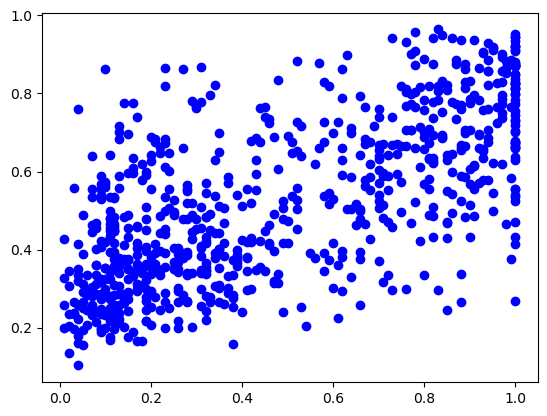

In [55]:
import matplotlib.pyplot as plt
r2 = metrics.r2_score(list_solubility_real, list_pred_real)
print(r2)


plt.scatter(list_solubility_real, list_pred_real,color='blue')

In [62]:
analysis(list_solubility_real, list_pred_real)

{'r2': 0.4346736535097122,
 'rmse': 0.06031453666557365,
 'binary_acc': 0.7865771812080536,
 'precision': 0.7299465240641712,
 'recall': 0.824773413897281,
 'f1': 0.7744680851063831,
 'auc': 0.8571960243443234,
 'mcc': 0.5772009509861091,
 'sensitivity': 0.824773413897281,
 'specificity': 0.7560386473429952}

In [61]:
columns=['label','prediction','solubility']
df = pd.DataFrame(list(zip(list_label_real, list_pred_real,list_solubility_real)))
df.columns = columns
print(df)

     label  prediction  solubility
0     1374    0.834577        0.48
1      610    0.560570        0.10
2      430    0.336913        0.88
3     2155    0.555670        0.28
4     1617    0.375149        0.12
..     ...         ...         ...
740   2169    0.886742        0.99
741   2237    0.420446        0.41
742   2308    0.402169        0.35
743   2561    0.402970        0.35
744   1237    0.772498        1.00

[745 rows x 3 columns]


In [63]:
df.to_csv("C:\\Users\\johnkwon\\Desktop\\[Ultima]_Solubility\\Data\\Ecoli_data\\Testing\\Stacking\\GCN_testing.csv")


